# Initialize the accelerator

In [1]:
#! apt-get install libhdf5-dev -y
#! pip install --upgrade pip setuptools wheel
#! pip install versioned-hdf5
#! pip install h5py
#! pip install bitstring
import os
import sys

#which prototype accelerator to load
deploy_path = '/home/xilinx/radioml_deploy/G_remake'
frequency = 250.0

driver_module_path = os.path.abspath(os.path.join(deploy_path, 'driver/'))
bitstream_path = os.path.abspath(os.path.join(deploy_path, 'bitfile/finn-accel.bit'))

In [2]:
# load driver from directory (don't use installed finn-examples driver)
if driver_module_path not in sys.path:
    sys.path.append(driver_module_path)

from driver_base import FINNExampleOverlay
from qonnx.core.datatype import DataType

from driver import io_shape_dict
# taken from generated driver.py:
#io_shape_dict = {
#    # FINN DataType for input and output tensors
#    "idt" : [DataType['INT8']],
#    "odt" : [DataType['UINT8']],
#    # shapes for input and output tensors (NHWC layout)
#    "ishape_normal" : [(1, 1024, 1, 2)],
#    "oshape_normal" : [(1, 1)],
#    # folded / packed shapes below depend on idt/odt and input/output
#    # PE/SIMD parallelization settings -- these are calculated by the
#    # FINN compiler.
#    "ishape_folded" : [(1, 256, 1, 1, 8)],
#    "oshape_folded" : [(1, 1, 1)],
#    "ishape_packed" : [(1, 256, 1, 1, 8)],
#    "oshape_packed" : [(1, 1, 1)],
#    "input_dma_name" : ['idma0'],
#    "output_dma_name" : ['odma0'],
#    "number_of_external_weights": 0,
#    "num_inputs" : 1,
#    "num_outputs" : 1,
#}

In [3]:
# manual FINNExampleOverlay instantiation (don't use models.py from finn-examples)
# this programs the device
accel = FINNExampleOverlay(
        bitfile_name = bitstream_path, platform = "zynq-iodma",
        io_shape_dict = io_shape_dict, batch_size = 1, fclk_mhz = frequency)

In [4]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal(0)), str(accel.idt(0))))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal(0)), str(accel.odt(0))))

Expected input shape and datatype: (1, 1024, 1, 2) INT8
Expected output shape and datatype: (1, 1) UINT8


In [5]:
# Run throughput test continuously for power testing
import numpy as np
import time
from pynq.ps import Clocks
from qonnx.util.basic import gen_finn_dt_tensor

accel.batch_size = 30000

# PREPARE A BATCH OF RANDOM INPUT DATA
print("GENERATING RANDOM INPUT BATCH..")
input_npy = np.random.randint(-128, 128, accel.ishape_normal(0), np.int8)
ibuf_folded = accel.fold_input(input_npy, ind=0)
ibuf_packed = accel.pack_input(ibuf_folded, ind=0)
accel.copy_input_data_to_device(ibuf_packed, ind=0)

print("STARTING POWER TEST..")
res = {}
start = time.time()
for i in range(1000):
    accel.execute_on_buffers()
end = time.time()
print("FINISHED POWER TEST")


runtime = end - start
res["runtime[ms]"] = runtime * 1000
res["throughput[images/s]"] = accel.batch_size / runtime
res["fclk[mhz]"] = Clocks.fclk0_mhz
res["batch_size"] = accel.batch_size

print(res)

GENERATING RANDOM INPUT BATCH..
STARTING POWER TEST..
FINISHED POWER TEST
{'runtime[ms]': 124240.4088973999, 'throughput[images/s]': 241.46733149256272, 'fclk[mhz]': 249.9975, 'batch_size': 30000}


# Load RadioML 2018 dataset

In [5]:
import numpy as np
import math
import pickle
import os
import h5py

dataset_dir = "/home/xilinx/dataset/RadioML/2018"
print(dataset_dir)

/home/xilinx/dataset/RadioML/2018


In [6]:
h5_file = h5py.File(dataset_dir + "/GOLD_XYZ_OSC.0001_1024.hdf5",'r')
data_h5 = h5_file['X']
label_mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
label_snr = h5_file['Z'][:,0]

# assemble list of test set indices
# do not pre-load large dataset into memory
np.random.seed(2018)
test_indices = []
for mod in range(0, 24): #all modulations (0 to 23)
    for snr_idx in range(0, 26): #all SNRs (0 to 25 = -20dB to +30dB)
        start_idx = 26*4096*mod + 4096*snr_idx
        indices_subclass = list(range(start_idx, start_idx+4096))

        split = int(np.ceil(0.1 * 4096)) #90%/10% split
        np.random.shuffle(indices_subclass)
        train_indices_subclass, val_indices_subclass = indices_subclass[split:], indices_subclass[:split]

        if snr_idx >= 25: #select which SNRs to test on
            test_indices.extend(val_indices_subclass)

test_indices = sorted(test_indices)

# note: labels given in the "classes.txt" file are not in the correct order (https://github.com/radioML/dataset/issues/25)
mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
'16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

In [7]:
print(data_h5.shape)
print(label_mod.shape)
print(label_snr.shape)
print(len(test_indices))

(2555904, 1024, 2)
(2555904,)
(2555904,)
9840


# Inspect a single sample

Modulation: BPSK, SNR: 30.0 dB


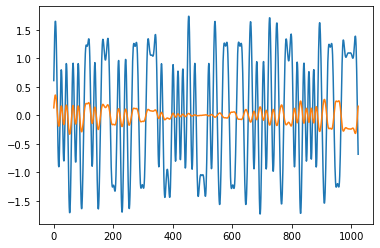

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

# Inspect a frame
mod = 3 # 0 to 23
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 122 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = data_h5[idx], label_mod[idx], label_snr[idx]
plt.figure()
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Input Quantization (on-the-fly)

In [9]:
def quantize(data):
    quant_min = -2.0
    quant_max = 2.0
    quant_range = quant_max - quant_min
    data_quant = (data - quant_min) / quant_range
    data_quant = np.round(data_quant * 256) - 128
    data_quant = np.clip(data_quant, -128, 127)
    data_quant = data_quant.astype(np.int8)
    return data_quant

# Classify a single sample

In [10]:
accel_in = quantize(data).reshape(accel.ishape_normal(0))
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 1024, 1, 2) and datatype is int8


In [11]:
accel_out = accel.execute(accel_in)

In [12]:
print("Result: " + str(accel_out))
print("Top-1 class predicted by the accelerator: " + mod_classes[int(accel_out)])

Result: [[3.]]
Top-1 class predicted by the accelerator: BPSK


In [13]:
%%timeit
accel_out = accel.execute(accel_in)

687 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Validate accuracy on entire validation set

In [13]:
batch_size = 1000
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed(0)), str(accel.oshape_packed(0))) )
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_folded(0)), str(accel.oshape_folded(0))) )
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_normal(0)), str(accel.oshape_normal(0))) )

Accelerator buffer shapes are (1000, 1024, 1, 1, 2) for input, (1000, 1, 1) for output
Accelerator buffer shapes are (1000, 1024, 1, 1, 2) for input, (1000, 1, 1) for output
Accelerator buffer shapes are (1000, 1024, 1, 2) for input, (1000, 1) for output


In [14]:
ok = 0
nok = 0
total = len(test_indices)
for i_batch in range(math.ceil(total/batch_size)):
    i_frame = i_batch*batch_size
    if i_frame+batch_size > total:
        batch_size = total - i_frame
        accel.batch_size = batch_size
    batch_indices = test_indices[i_frame:i_frame+batch_size]
    data, mod, snr = data_h5[batch_indices], label_mod[batch_indices], label_snr[batch_indices]

    ibuf = quantize(data).reshape(accel.ishape_normal(0))
    obuf = accel.execute(ibuf)

    pred = obuf.reshape(batch_size).astype(int)

    ok += np.equal(pred, mod).sum().item()
    nok += np.not_equal(pred, mod).sum().item()
    
    print("batch %d : total OK %d NOK %d" % (i_batch, ok, nok))

batch 0 : total OK 1000 NOK 0
batch 1 : total OK 2000 NOK 0
batch 2 : total OK 2998 NOK 2
batch 3 : total OK 3996 NOK 4
batch 4 : total OK 4989 NOK 11
batch 5 : total OK 5973 NOK 27
batch 6 : total OK 6836 NOK 164
batch 7 : total OK 7457 NOK 543
batch 8 : total OK 8417 NOK 583
batch 9 : total OK 9257 NOK 583


In [15]:
acc = 100.0 * ok / (total)
print("Measured top-1 accuracy: {}%".format(acc))

Measured top-1 accuracy: 94.07520325203252%


## Benchmarking

In [16]:
# Run throughput test once
accel.batch_size = 1000
print(accel.throughput_test())
accel.batch_size = 10000
print(accel.throughput_test())
accel.batch_size = 30000
print(accel.throughput_test())

{'runtime[ms]': 4.335641860961914, 'throughput[images/s]': 230646.35688754468, 'DRAM_in_bandwidth[Mb/s]': 472.3637389056915, 'DRAM_out_bandwidth[Mb/s]': 0.23064635688754467, 'fclk[mhz]': 249.9975, 'batch_size': 1000, 'fold_input[ms]': 0.08153915405273438, 'pack_input[ms]': 0.060558319091796875, 'copy_input_data_to_device[ms]': 2.0253658294677734, 'copy_output_data_from_device[ms]': 0.12421607971191406, 'unpack_output[ms]': 0.46634674072265625, 'unfold_output[ms]': 0.06103515625}
{'runtime[ms]': 41.571855545043945, 'throughput[images/s]': 240547.3575545551, 'DRAM_in_bandwidth[Mb/s]': 492.6409882717289, 'DRAM_out_bandwidth[Mb/s]': 0.2405473575545551, 'fclk[mhz]': 249.9975, 'batch_size': 10000, 'fold_input[ms]': 0.09202957153320312, 'pack_input[ms]': 0.0667572021484375, 'copy_input_data_to_device[ms]': 18.66745948791504, 'copy_output_data_from_device[ms]': 0.12874603271484375, 'unpack_output[ms]': 0.4763603210449219, 'unfold_output[ms]': 0.06270408630371094}
{'runtime[ms]': 124.3233680725

In [6]:
# Run throughput test continuously for power testing
import time
from pynq.ps import Clocks
from qonnx.util.basic import gen_finn_dt_tensor

accel.batch_size = 30000

# PREPARE A BATCH OF RANDOM INPUT DATA
print("GENERATING RANDOM INPUT BATCH..")
input_npy = np.random.randint(-128, 128, accel.ishape_normal(0), np.int8)
ibuf_folded = accel.fold_input(input_npy, ind=0)
ibuf_packed = accel.pack_input(ibuf_folded, ind=0)
accel.copy_input_data_to_device(ibuf_packed, ind=0)

print("STARTING POWER TEST..")
res = {}
start = time.time()
for i in range(1000):
    accel.execute_on_buffers()
end = time.time()
print("FINISHED POWER TEST")


runtime = end - start
res["runtime[ms]"] = runtime * 1000
res["throughput[images/s]"] = accel.batch_size / runtime
res["fclk[mhz]"] = Clocks.fclk0_mhz
res["batch_size"] = accel.batch_size

print(res)

GENERATING RANDOM INPUT BATCH..
STARTING POWER TEST..
FINISHED POWER TEST
{'runtime[ms]': 124480.26490211487, 'throughput[images/s]': 241.0020578249132, 'fclk[mhz]': 249.9975, 'batch_size': 30000}
